# Vaximap dataset analysis: time saving estimates 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from pyproj import Transformer
import matplotlib.pyplot as plt
from scipy import spatial, optimize
from matplotlib.cm import get_cmap
import matplotlib.dates as mdates
from collections import Counter
import sys
sys.path.append('..')
from load_dataset import dataset as dataset_repeat

Loading database ../load_dataset/nov_2021.h5


`UK_CENTER` is used to shift all relative latlong coords onto the approximate center of the UK. `DETOUR_INDEX` is selected from the literature as the midpoint of the quoted range of 1.2 to 1.6. `REPEAT_THRESHOLD` is set at 21 days, the minimum permissible time between identical requests. `MAX_PAIR_DIST` is set to 64 km, the maximum allowed distance between individual patients. Distances greater than this are assumed to be due to geocoding errors and will be zeroed. 

In [2]:
CMAP = np.array(get_cmap('tab10').colors)
UK_CENTER = (53, -1.2)
DETOUR_INDEX = 1.4
REPEAT_THRESHOLD = 21 # days 
MEAN_SPEED = 50 # kmh 
MAX_PAIR_DIST = 64e3 # km 

These values are taken from the linear regressions performed in the `survey/survey_analysis` notebook; both are in seconds per patient location

In [3]:
LOOKUP_COEFFICIENT = 37.0/60
ROUTING_COEFFICIENT = 4.7/60

This is what a single row of the raw dataset (including repeats) looks like 

In [4]:
print("Length of raw dataset = {:,}".format(len(dataset_repeat)))
print("Number of patients in raw dataset = {:,}".format(dataset_repeat.n_patients.sum()))
dataset_repeat.head(1)

Length of raw dataset = 9,501
Number of patients in raw dataset = 314,861


,n_patients,n_clusters,latlong,clusters,region,postcodes,created,mode
0,6,1,"[[-0.0011351833333321792, -0.03472788333333332...","[[2, 3, 5, 4, 1, 0]]",UK,{},2021-01-23,driving


## Repeat removal

Identifying and removing repeat requests below `REPEAT_THRESHOLD`. We also need to remove the testing dataset (ID 2058)

In [5]:
# Test to identify duplicates: need to convert latlong numpy to string beforehand to be able to drop
df1 = dataset_repeat.copy()[["latlong"]]
df1.latlong = df1.latlong.astype("str")
df1 = df1.sort_values("latlong")

# extract number of duplicates from pandas duplicated inbuilt function
df1["is_duplicate"] = df1.duplicated(subset="latlong", keep="last")
print("Number of duplicates = {:,}".format(len(df1.loc[df1.is_duplicate == True])))
print("Number of distinct sets in dataset = {}".format(len(df1.loc[df1.is_duplicate == False])))

Number of duplicates = 3,051
Number of distinct sets in dataset = 6450


In [6]:
# Demonstrate example of duplicate indices:
df1["is_duplicate_keep_both"] = df1.duplicated(subset="latlong", keep=False)
df1.loc[df1.is_duplicate_keep_both == True][15:18].reset_index()

,index,latlong,is_duplicate,is_duplicate_keep_both
0,174,[[ 0.00013685 0.0024527 ]\n [-0.00220345 0.0...,True,True
1,175,[[ 0.00013685 0.0024527 ]\n [-0.00220345 0.0...,True,True
2,176,[[ 0.00013685 0.0024527 ]\n [-0.00220345 0.0...,False,True


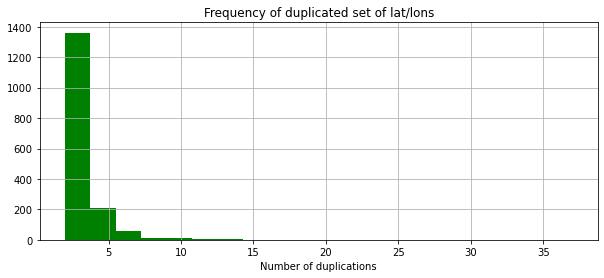

In [7]:
# plot histogram of frequency of duplicate set occurring (not showing cases without duplicates)
x = df1.groupby("latlong").count().sort_values("is_duplicate", ascending=False)
x = x.loc[x.is_duplicate > 1]

plt.figure(figsize=(10,4))
plt.grid()
plt.title("Frequency of duplicated set of lat/lons")
plt.xlabel("Number of duplications")
plt.hist(x.is_duplicate, bins=20, color="green")
plt.show()

In [8]:
# create record_id and join to dataset
idf = df1.sort_values("latlong")
idn = 1
id_list = [1]

for i in range(1, len(idf)):
    if idf.latlong.values[i] == idf.latlong.values[i - 1]:
        id_list.append(idn)
    else:
        idn += 1
        id_list.append(idn)
        
idf["record_id"] = id_list

# join
dataset_repeat = dataset_repeat.join(idf[["record_id"]])

In [9]:
# Check duration between duplicates
dataset_repeat["created"] = pd.to_datetime(dataset_repeat["created"])

dup = df1.loc[df1.is_duplicate_keep_both == True]
dup = dup.join(idf[["record_id"]])

time_bet = pd.DataFrame()

for latlong in dup.latlong.unique()[:]:
    dup1 = dup.loc[dup.latlong == latlong]
    index_list = dup1.index.values
    dat = dataset_repeat.iloc[index_list].sort_values("created")
    dat["time_between"] = (dat["created"] - dat["created"].shift(1)).dt.days
    time_bet = time_bet.append(dat[:])


Can see here that vast majority of duplicates occur same day, only a minority occurring on further days

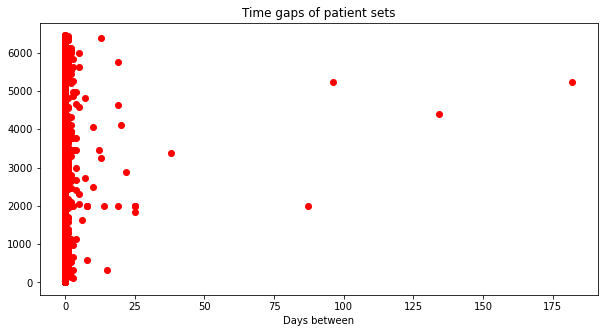

In [10]:
# for each record plot the time gaps - note y axis is record id (so cardinality is meaningless)
plt.figure(figsize=(10,5))
plt.title("Time gaps of patient sets")
plt.xlabel("Days between")
plt.plot(time_bet.time_between, time_bet.record_id, "ro")
plt.show()

In [11]:
# plot scatters comparing days between duplicates vs number of duplicates 

# dataframe to get average duration per duplicate per set
record_time_bet = time_bet.groupby("record_id").mean()
record_time_bet = record_time_bet.join(dup.groupby("record_id").count()[["latlong"]].rename(columns={"latlong" : "occurrences"}))

# filter for those where mean time > 0
record_time_bet1 = record_time_bet.loc[record_time_bet.time_between > 0]

In [12]:
# records with large occurrences
record_time_bet.loc[record_time_bet.occurrences > 10]

,n_patients,n_clusters,time_between,occurrences
record_id,,,,
100,8.0,1.000000,0.000000,18
205,33.0,3.000000,0.000000,11
2000,24.0,4.000000,3.238095,22
2058,24.0,2.945946,0.361111,37
3190,116.0,12.642857,0.000000,14
3463,6.0,1.125000,1.133333,16
4588,116.0,11.000000,0.600000,11
5607,114.0,13.000000,0.000000,12
6134,285.0,32.000000,0.000000,13


In [13]:
# records with long timespan
record_time_bet.loc[record_time_bet.time_between > 10]

,n_patients,n_clusters,time_between,occurrences
record_id,,,,
336,8.0,1.0,15.000000,2
1827,8.0,1.0,25.000000,2
1999,24.0,3.0,26.666667,7
2871,32.0,2.5,22.000000,2
3252,8.0,1.0,13.000000,2
3381,9.0,1.0,38.000000,2
4113,5.0,1.0,20.000000,2
4386,6.0,1.0,33.500000,5
5221,7.0,1.0,91.000000,3


## Repeat analysis 
The irrelevant repeats have been removed; what can we say about the ones that remain?

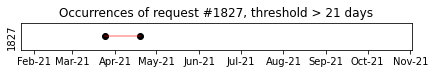

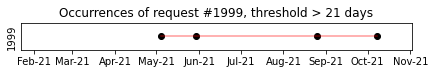

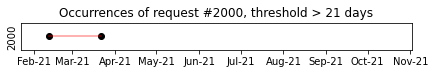

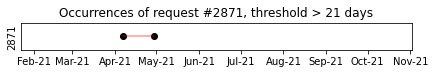

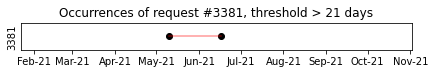

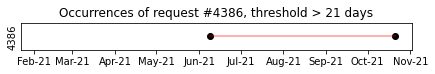

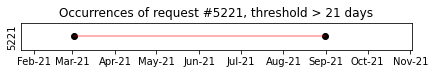

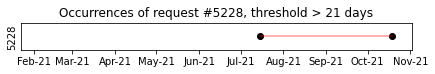

In [14]:
# we set a threshold to say valid repeats are those that occur a certain number of days after a previous request
z = time_bet.loc[time_bet.record_id.isin(time_bet.loc[time_bet.time_between >= REPEAT_THRESHOLD].record_id.unique())]
z = z.loc[(z.time_between >= REPEAT_THRESHOLD) | (z.time_between.isnull())]

for record in z.record_id.unique():
    plt.figure(figsize=(7,0.5))
    z1 = z.loc[z.record_id == record]
    x = pd.to_datetime(z1.created)
    plt.xlim(dataset_repeat.created.min(), dataset_repeat.created.max())
    plt.title("Occurrences of request #{}, threshold > {} days"
                .format(record, REPEAT_THRESHOLD))
    plt.plot(x, z1.record_id, "r", alpha=0.4)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    plt.scatter(z1.created, z1.record_id, color="black")
    plt.yticks([])
    plt.ylabel(record)

    if record == 1999: 
        plt.savefig('a_repeat.png', dpi=250, bbox_inches='tight')
    


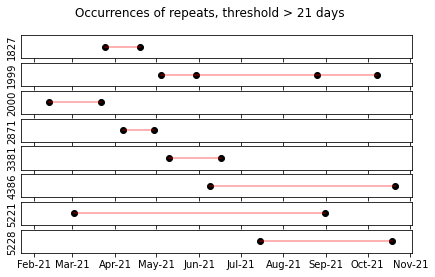

In [15]:
unique_records = z.record_id.unique()
fig, axes = plt.subplots(len(unique_records), 1, sharex=True, figsize=(7,4))
fig.suptitle("Occurrences of repeats, threshold > {} days"
                .format(REPEAT_THRESHOLD))
for ax, record in zip(axes, unique_records):
    z1 = z.loc[z.record_id == record]
    x = pd.to_datetime(z1.created)
    ax.set_xlim(dataset_repeat.created.min(), dataset_repeat.created.max())

    ax.plot(x, z1.record_id, "r", alpha=0.4)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    ax.scatter(z1.created, z1.record_id, color="black")
    ax.set_yticks([])
    ax.set_ylabel(record)

plt.savefig('many_repeats.png', dpi=250, bbox_inches='tight')

It appears that the ID=2058 is Tom's test dataset.

In [16]:
# we remove from dataset Tom's test set for EDA
dataset_repeat = dataset_repeat.loc[dataset_repeat.record_id != 2058]

# Remove duplicate indices from raw dataset, keeping "last" assuming earlier duplicates were for testing
repeat_keep_indices = time_bet.loc[(time_bet.time_between >= REPEAT_THRESHOLD) | (time_bet.time_between.isnull())].index
dataset_nonrepeat = dataset_repeat.loc[(dataset_repeat.index.isin(df1.loc[df1.is_duplicate_keep_both == False].index.values)) | (dataset_repeat.index.isin(repeat_keep_indices))]
print("Length of dataset without repeats = {:,}".format(len(dataset_nonrepeat)))
print("Number of patients in dataset without repeats = {:,}".format(dataset_nonrepeat.n_patients.sum()))
print("Length of dataset with repeats = {:,}".format(len(dataset_repeat)))
print("Number of patients in dataset with repeats = {:,}".format(dataset_repeat.n_patients.sum()))

Length of dataset without repeats = 6,459
Number of patients in dataset without repeats = 198,023
Length of dataset with repeats = 9,464
Number of patients in dataset with repeats = 313,973


## Time savings in planning 

In [17]:
lookup_time = dataset_repeat.n_patients.sum() * LOOKUP_COEFFICIENT
routing_time = dataset_repeat.n_patients.sum() * ROUTING_COEFFICIENT 
planning_time_hrs = (lookup_time + routing_time) / 60
print('Time saved in planning %d hours' % planning_time_hrs)
print('Time saved in planning %d weeks (40hr week)' % (planning_time_hrs / 40))

Time saved in planning 3636 hours
Time saved in planning 90 weeks (40hr week)


## Time savings in travelling 
We are lifting the optimisation penalty function for human performance reported in figure 2b of Dry, Matthew; Lee, Michael D; Vickers, Douglas; Hughes, Peter; Human Performance on Visually Presented Traveling Salesperson Problems with Varying Numbers of Nodes, The Journal of Problem Solving, 2006

In [18]:
# optimisation penalty 
n = np.array([0, 10, 20, 30, 40, 50, 70, 90, 120])
p = np.array([0, 0.02, 0.025, 0.06, 0.075, 0.095, 0.105, 0.11, 0.12])

# Assume a relation of the form y = A(1 - e(-n/B))
def curve(x, A, B):
    return A * (1 - np.exp(-x / B))

params = optimize.curve_fit(curve, n.flatten(), p.flatten())[0]

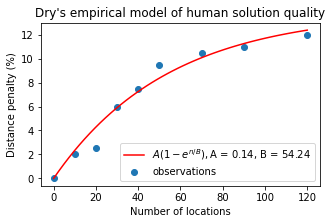

In [19]:
plt.figure(figsize=(5,3))
plt.scatter(n.flat, 100 * p.flatten(), label='observations')
n_fit = np.linspace(0,120)
p_fit = curve(n_fit, *params)
plt.plot(n_fit, 100 * p_fit, 'r-', label=r'$A(1 - e^{n/B}), $' + f'A = {params[0]:.2f}, B = {params[1]:.2f}' )

plt.xlabel('Number of locations')
plt.ylabel('Distance penalty (%)')
plt.title('Dry\'s empirical model of human solution quality')
plt.legend(loc='lower right')
plt.savefig('dry_model.png', dpi=250, bbox_inches='tight')

In [20]:
# Calculating the distance implied by all Vaximap routes. 
# The coordinates are stored in the dataset as latitude and longitude, so we need to convert into a metric 
# coordinate system (EPSG3857) and then can use distance matrices to work out the length of each closed route 
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

def get_vaximap_route_length(latlong, routes):
    lat, lng = (latlong + UK_CENTER).T
    ll_m = transformer.transform(lng, lat)
    ll_m = np.vstack(ll_m).T
    dm = spatial.distance_matrix(ll_m, ll_m)
    dm[dm > MAX_PAIR_DIST] = 0 
    total = 0 
    for route in routes: 
        rt_length = sum([ dm[route[x], route[x+1]] for x in range(len(route) - 1) ])
        rt_length += dm[route[-1], route[0]]
        total += rt_length
    return total

# Calculate total length of routes for each request (ie, row of dataset). Then, we can apply the manual distance
# penalty which is a function of the total number of patients in the request 
dataset_nonrepeat = dataset_nonrepeat.assign(vaximap_distance=[ 
                        get_vaximap_route_length(row.latlong, row.clusters) 
                        for row in dataset_nonrepeat.loc[:,['latlong', 'clusters']].itertuples() ])
dataset_nonrepeat =  dataset_nonrepeat.assign(manual_distance= 
                        (dataset_nonrepeat['vaximap_distance'] 
                         * (1 + params[0] * (1 - np.exp(-dataset_nonrepeat['n_patients'] / params[1])))))

In [21]:
# Route lengths are in meters. Apply the detour index, convert into km, and apply average speed to convert into time 
dist_saving = DETOUR_INDEX * (dataset_nonrepeat['manual_distance'] - dataset_nonrepeat['vaximap_distance']).sum() / 1000
dist_saving_hrs = dist_saving / 50
print('travel savings %d km' % dist_saving)
print('travel savings %d hours' % dist_saving_hrs)
print('travel savings %d weeks (40hr week)' % (dist_saving_hrs / 40))
total_savings_hrs = dist_saving_hrs + planning_time_hrs
print('total savings %d hours' % total_savings_hrs)
print('total savings %d weeks (40hr week)' % (total_savings_hrs / 40))

travel savings 31613 km
travel savings 632 hours
travel savings 15 weeks (40hr week)
total savings 4269 hours
total savings 106 weeks (40hr week)


In [22]:
# Convert into cost savings 
pm_salary = 38e3 # practice manager
cn_salary = 32e3 # community nurse 
total_cost_savings = (pm_salary * planning_time_hrs / (40 * 48)) + (cn_salary * dist_saving_hrs / (40 * 48))
print('Total cost savings', total_cost_savings)

Total cost savings 82517.06801717395


## Summary plots 
A variety of plots showing high level summaries of dataset 

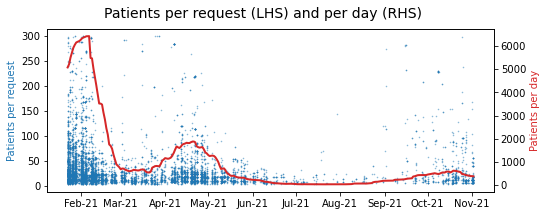

In [23]:
# sort the dataframe by date created
dataset_repeat['created'] = pd.to_datetime(dataset_repeat.created)
dataset_repeat = dataset_repeat.sort_values(by='created')

# define average patients per cluster
dataset_repeat['patients_per_cluster'] = (dataset_repeat['n_patients']/dataset_repeat['n_clusters'])

# get the raw data
y = dataset_repeat.n_patients
x = dataset_repeat.created

# bin the data by date
binned = dataset_repeat['n_patients'].groupby(dataset_repeat['created']).sum()
x_binned = binned.index
y_binned = binned.values

def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def add_titlebox(ax, text):
    ax.text(.67, .8, text,
        horizontalalignment='center',
         transform=ax.transAxes,
         bbox=dict(facecolor='white', alpha=0.2),
         fontsize=12.5)
    return ax

fig, ax1 = plt.subplots(1,1, figsize=(8, 3))
ax11= ax1.twinx()

# Headline figure
fig.suptitle('Patients per request (LHS) and per day (RHS)',
              fontsize=14)
sctr = ax1.scatter(x, y, color='tab:blue', alpha=0.5, s=0.3)
y_av = movingaverage(y_binned, 30)
ax11.plot(x_binned, y_av, "tab:red", linewidth=2)
ax1.set_yscale('linear')
ax1.set_ylabel('Patients per request', color='tab:blue')
#ax1.text(0.8, 0.8, r'A', fontsize=15,transform=ax.transAxes)
ax11.set_ylabel('Patients per day', color='tab:red')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
plt.savefig('timeseries.png', dpi=250, bbox_inches='tight')

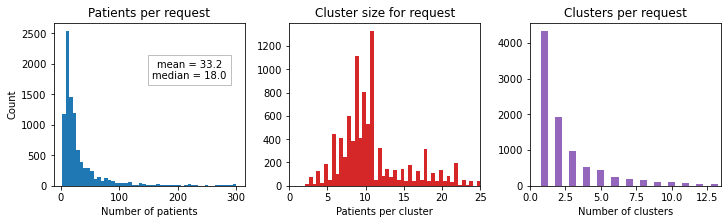

In [24]:
# Patients per route
fig, axes = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)

ax1 = axes[0]
ax1.hist(dataset_repeat.n_patients, bins=50)
ax1.set_xlabel('Number of patients')
ax1.set_ylabel('Count')
ax1.set_title('Patients per request')
ax1.text(220, 1750, f'mean = {dataset_repeat.n_patients.mean():.1f}\n'
                    +f'median = {dataset_repeat.n_patients.median():.1f}',
        horizontalalignment='center',
        bbox=dict(facecolor='white', alpha=0.25))

ax2 = axes[1]
binwidth=0.5
ax2.hist(dataset_repeat.patients_per_cluster, bins=np.arange(min(dataset_repeat.patients_per_cluster), 
                                                      max(dataset_repeat.patients_per_cluster) + binwidth, binwidth),
         color='tab:red', align='left')
ax2.axis(xmin=0,xmax=25)
ax2.set_title('Cluster size for request')
ax2.set_xlabel('Patients per cluster')

# Clusters per route
ax3 = axes[2]
binwidth=0.5
ax3.hist(dataset_repeat.n_clusters, bins=np.arange(min(dataset_repeat.n_clusters), 
                                            max(dataset_repeat.n_clusters) + binwidth, binwidth),
                                            align='left', color='tab:purple')
ax3.axis(xmin=0,xmax=13.5)
ax3.set_title('Clusters per request')
ax3.set_xlabel('Number of clusters')

plt.savefig('hists.png', dpi=250, bbox_inches='tight')

## Geographic analysis
Extract postcodes (to be plotted via another program not available here)

In [25]:
has_pc = [ bool(pc) for pc in dataset_repeat.postcodes ]
print(f'{len(has_pc)} rows, {sum(has_pc)} have postcodes')

9464 rows, 3113 have postcodes


In [26]:
pc_counts = Counter() 
[ pc_counts.update(pc) for pc in dataset_repeat.postcodes.tolist() ] 

df = pd.DataFrame(data={"postcodes" : pc_counts.keys(), "num" : pc_counts.values()})
df1 = df.groupby("postcodes").sum()
df1["name"] = df1.index.str[:2]
df1.to_csv("postcodes.csv", header=True)